# GAN toy example

The notebook containts a toy example where you train a model to fit a Gaussian Mixture (ring of gaussians).
All you have to do is complete the training loop by filling in the discriminator and generator update step and you are ready to train. If your training loop works, the progression of your training should look as in the output you can see at the bottom of the notebook. :slight_smile:
In this way, you can test that you understood how the training in GANs works by isolating the training problem. Once you have your training loop running, you can move on to the more difficult exercise  problem with MNIST (which might have more error sources).

In [190]:
import sys
import itertools
import types
from collections import OrderedDict

import seaborn

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

import matplotlib.pyplot as plt
%matplotlib inline

In [191]:
class GaussianMixture:
  def __init__(self, count: int, std=0.02, radius=2.0):
    self.count = count
    self.std = std
    self.radius = radius
    angles = torch.arange(0, 2*np.pi, 2*np.pi/count, out=torch.FloatTensor())
    self.centers = torch.stack([radius * torch.sin(angles), radius * torch.cos(angles)], dim=1)

  def sample(self, batch_size: int):
    distrib = torch.distributions.Categorical(torch.ones((1, self.count), dtype=torch.float32))
    center_idx = distrib.sample((batch_size,)).squeeze()
    sample = torch.FloatTensor(batch_size, 2).normal_() * self.std + self.centers[center_idx]
    return sample

In [192]:
batch_size = 512
latent_dim = 128
hidden_dim = 256

In [194]:
class Generator(nn.Module):
  def __init__(self, latent_dim, hidden_dim):
    super(Generator, self).__init__()
    self.body = nn.Sequential(OrderedDict([
      ('fc1', nn.Linear(latent_dim, hidden_dim)),
      ('relu', nn.ReLU()),
      ('fc2', nn.Linear(hidden_dim, 2))
    ]))
  
  def forward(self, x):
    return self.body(x)

class Discriminator(nn.Module):
  def __init__(self, hidden_dim):
    super(Discriminator, self).__init__()
    self.body = nn.Sequential(OrderedDict([
      ('fc1', nn.Linear(2, hidden_dim)),
      ('relu', nn.ReLU()),
      ('fc2', nn.Linear(hidden_dim, 1))
    ]))

  def forward(self, x):
    return self.body(x)


generator = Generator(latent_dim, hidden_dim)
discriminator = Discriminator(hidden_dim)
generator.cuda()
discriminator.cuda()
d_optim = torch.optim.Adam(discriminator.parameters(), lr=1e-3)
g_optim = torch.optim.Adam(generator.parameters(), lr=1e-3)

In [196]:
summary(discriminator, input_size=(1,2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]             768
              ReLU-2               [-1, 1, 256]               0
            Linear-3                 [-1, 1, 1]             257
Total params: 1,025
Trainable params: 1,025
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


As discussed in the tutorial exercise, the GAN loss can also be expressed as binary cross entropy with labels 1 for true samples and labels 0 for fake samples. We can use that to compute the loss criterion more conveniently in PyTorch: 

In [202]:
def train(
    generator: nn.Module, 
    discriminator: nn.Module, 
    g_optim: optim.Optimizer, 
    d_optim: optim.Optimizer, 
    batch_size=512, 
    latent_dim=128,
    max_iter=5000,
    plot_every=100,
    cuda=True
    ):
  
  mixture = GaussianMixture(8)
  criterion = nn.BCEWithLogitsLoss()
  if cuda:
    generator, discriminator = generator.cuda(), discriminator.cuda()

  for i in range(max_iter):
      noise = torch.FloatTensor(batch_size, latent_dim).normal_()
      real_data = mixture.sample(batch_size)
      if cuda:
        noise, real_data = noise.cuda(), real_data.cuda()
      
      # Discriminator update
      generator.eval()
      discriminator.train()
     
      d_optim.zero_grad()
      
      prediction_real = discriminator(real_data)
      loss_real = criterion(prediction_real, torch.ones(real_data.shape[0],1).cuda()) #g_loss = criterion(discriminator(gen_imgs), torch.ones([batch_size,1]).cuda())
      fake_data = generator(noise)
      prediction_fake = discriminator(fake_data)
      loss_fake = criterion(prediction_fake, torch.zeros(noise.shape[0],1).cuda())
      d_loss = (loss_real + loss_fake) / 2 
      
      d_loss.backward()
      d_optim.step()     
        
      # Generator Update
      generator.train()
      discriminator.eval()

      g_optim.zero_grad()

      fake_imgs = generator(noise)
      prediction_fake_imgs = discriminator(fake_imgs)
      g_loss = criterion(prediction_fake_imgs, torch.ones(noise.shape[0],1).cuda())
      
      g_loss.backward()
      g_optim.step()
      
      

      #Plot data:
      if i % plot_every == 0:
          xx_fake = fake_data.data.cpu().numpy()
          xx_real = real_data.data.cpu().numpy()
          
          generator.eval()
          noise = torch.FloatTensor(batch_size*10, latent_dim).normal_()
          if cuda:
            noise = noise.cuda()

          fake_data = generator(noise)
          fake_data_cpu = fake_data.data.cpu().numpy()
          
          sys.stdout.write(f'\rStep: {i}/{max_iter} D loss: {d_loss:.6f} G loss: {-g_loss:.6f}')

          fig, ax = plt.subplots(1, 2, figsize=(10,5))
          ax[0].scatter(xx_fake[:, 0], xx_fake[:, 1], edgecolor='w',alpha=0.6)
          ax[0].scatter(xx_real[:, 0], xx_real[:, 1], c='g', edgecolor='w', alpha=0.6)
          seaborn.kdeplot(x=fake_data_cpu[:, 0], y=fake_data_cpu[:, 1], shade=True, cmap='Greens', n_levels=20, clip=[[-2.5,2.5]]*2, ax=ax[1])
          plt.show()

Step: 0/5000 D loss: 0.730161 G loss: -0.765063

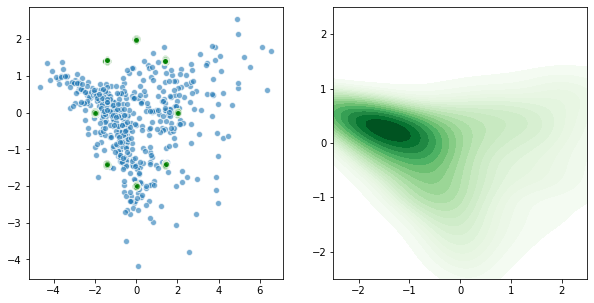

Step: 100/5000 D loss: 0.615989 G loss: -0.892359

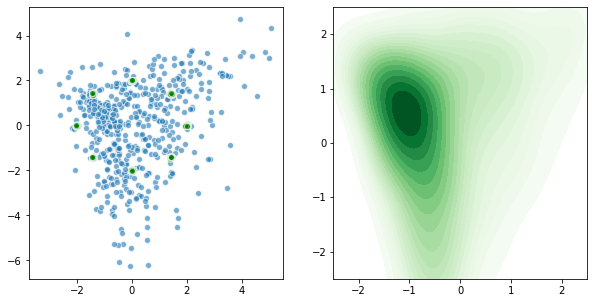

Step: 200/5000 D loss: 0.610387 G loss: -0.842035

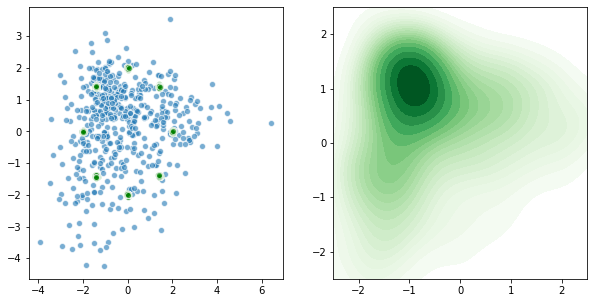

Step: 300/5000 D loss: 0.578912 G loss: -0.872599

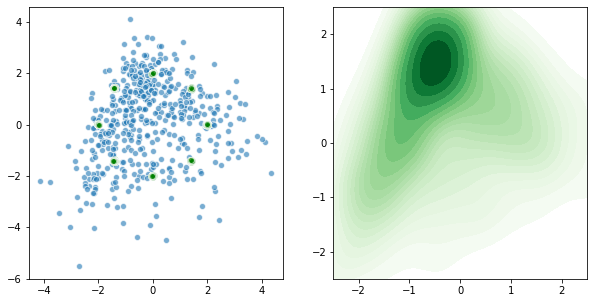

Step: 400/5000 D loss: 0.560115 G loss: -0.901376

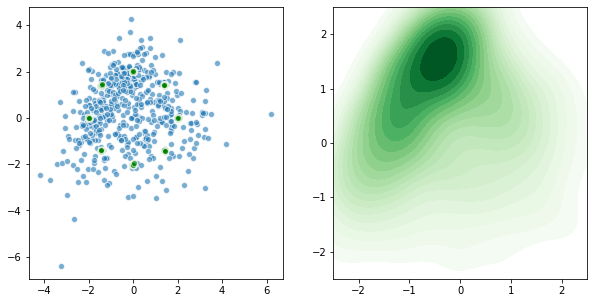

Step: 500/5000 D loss: 0.538526 G loss: -0.950617

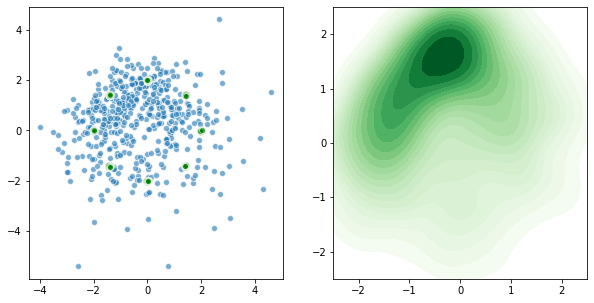

Step: 600/5000 D loss: 0.530037 G loss: -0.978930

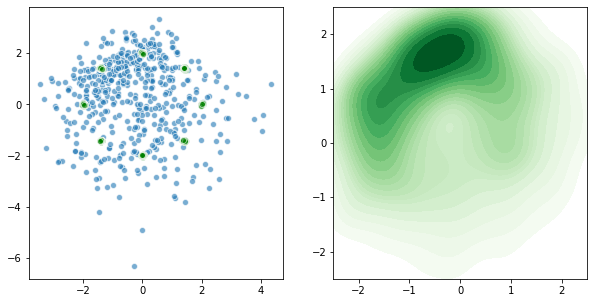

Step: 700/5000 D loss: 0.526189 G loss: -0.979985

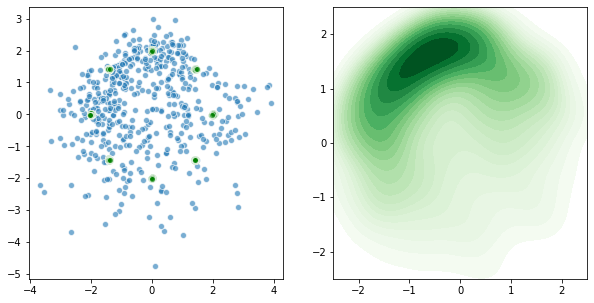

Step: 800/5000 D loss: 0.525197 G loss: -0.975984

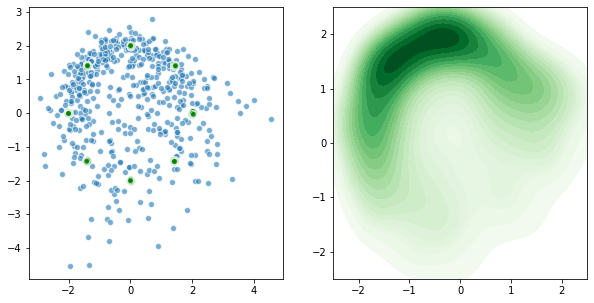

Step: 900/5000 D loss: 0.540880 G loss: -0.967601

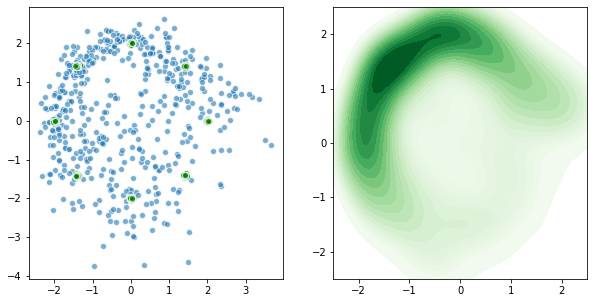

Step: 1000/5000 D loss: 0.544206 G loss: -0.905285

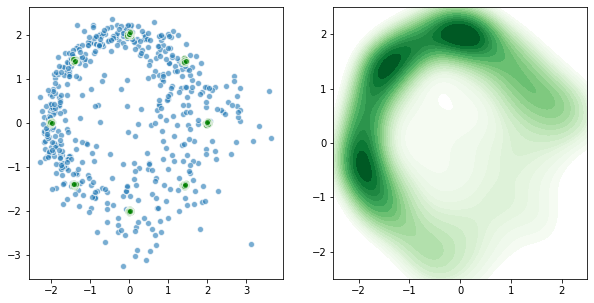

Step: 1100/5000 D loss: 0.556574 G loss: -0.911294

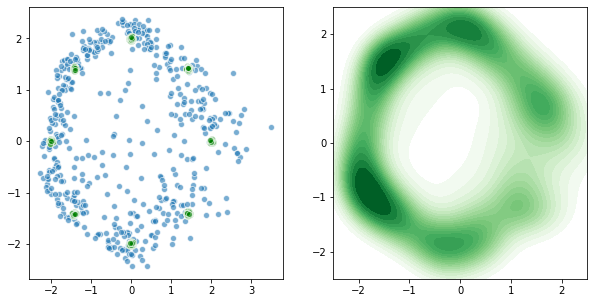

Step: 1200/5000 D loss: 0.556811 G loss: -0.917351

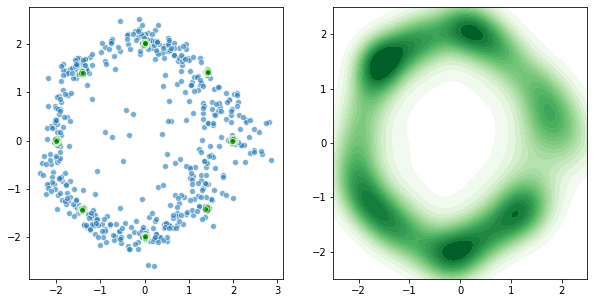

Step: 1300/5000 D loss: 0.562127 G loss: -0.904484

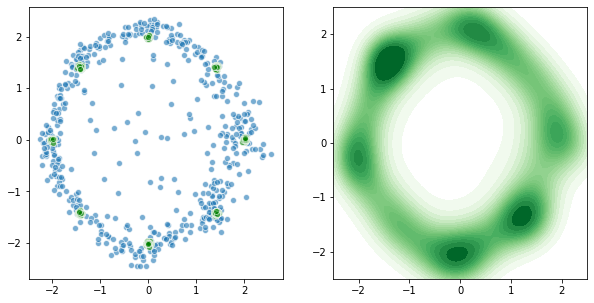

Step: 1400/5000 D loss: 0.560017 G loss: -0.895897

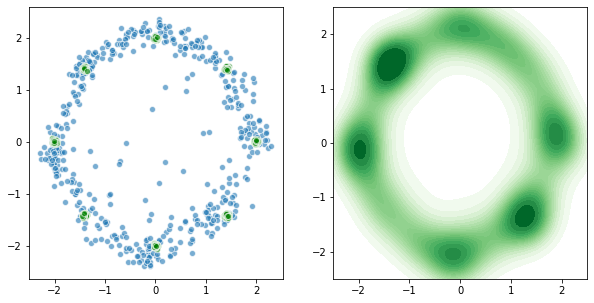

Step: 1500/5000 D loss: 0.567123 G loss: -0.882366

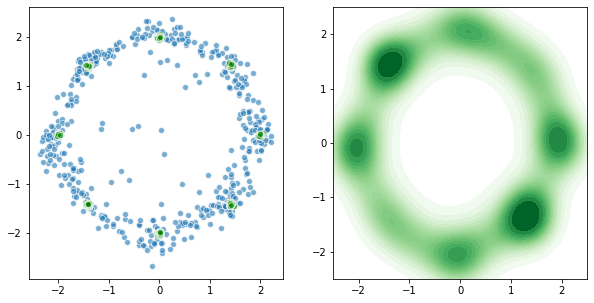

KeyboardInterrupt: ignored

In [203]:
train(generator, discriminator, g_optim, d_optim, max_iter=5000, plot_every=100, latent_dim=latent_dim, cuda=True)

# Exercise 1: GANs

Implement a GAN and train it on the MNIST dataset.

In [204]:
import sys
import itertools
import types
from collections import OrderedDict
from scipy.stats import norm
import pickle as pk
import seaborn
import imageio

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn import Parameter
from torch.autograd import grad
from torch.utils.data import Dataset, DataLoader
from typing import Union, Tuple
from torchsummary import summary
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.utils import make_grid, save_image

In [205]:
torch.cuda.is_available()

True

## Load MNIST data

In [206]:
DataPath = r"./"

train_data = datasets.MNIST(DataPath, train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_data, batch_size=len(train_data))
batch = next(iter(train_loader))
x, y = batch
mean, std = torch.mean(x), torch.std(x)
transform = transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
])

batch_size = 32
trainset = datasets.MNIST(root=DataPath, train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = datasets.MNIST(root=DataPath, train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)
to_pil_image = transforms.ToPILImage()

In [207]:
len(train_loader)

1875

In [208]:
next(iter(train_loader))[0].shape

torch.Size([32, 1, 28, 28])

## Implement GAN
Found inspiration in the following tutorials: 
1. https://debuggercafe.com/generating-mnist-digit-images-using-vanilla-gan-with-pytorch/
2. https://github.com/safwankdb/Vanilla-GAN/blob/master/Vanilla_GAN.ipynb

In [209]:
class Generator(nn.Module):
  def __init__(self, latent_dim, hidden_dim):
    super(Generator, self).__init__()
    self.body = nn.Sequential(OrderedDict([
      ('fc1', nn.Linear(latent_dim, hidden_dim)),
      ('relu', nn.LeakyReLU()),
      ('fc2', nn.Linear(hidden_dim, 784)),
    

    ]))
  
  def forward(self, x):
    return self.body(x).reshape([-1,28,28]) 

class Discriminator(nn.Module):
  def __init__(self, hidden_dim):
    super(Discriminator, self).__init__()
    self.body = nn.Sequential(OrderedDict([
      ('fc1', nn.Linear(784, hidden_dim)),
      ('relu1', nn.LeakyReLU()),
      ('fc2', nn.Linear(hidden_dim, 1))
    ]))

  def forward(self, x):
    x = x.reshape([-1,784])
    return self.body(x) 

In [210]:
batch_size = 32
latent_dim = 128
hidden_dim = 256
generator = Generator(latent_dim, hidden_dim)
discriminator = Discriminator(hidden_dim)
generator.cuda()
discriminator.cuda()
d_optim = torch.optim.Adam(discriminator.parameters(), lr=1e-3)
g_optim = torch.optim.Adam(generator.parameters(), lr=1e-3)

In [211]:
summary(generator, input_size=(1,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]          33,024
         LeakyReLU-2               [-1, 1, 256]               0
            Linear-3               [-1, 1, 784]         201,488
Total params: 234,512
Trainable params: 234,512
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.89
Estimated Total Size (MB): 0.90
----------------------------------------------------------------


In [212]:
summary(discriminator, input_size=(1,784))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         200,960
         LeakyReLU-2                  [-1, 256]               0
            Linear-3                    [-1, 1]             257
Total params: 201,217
Trainable params: 201,217
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.77
Estimated Total Size (MB): 0.77
----------------------------------------------------------------


## Train a GAN on the MNIST data

In [213]:
def sample_noise(size, dim):
  return torch.randn(size, dim)

In [242]:
def train(
    generator: nn.Module, 
    discriminator: nn.Module, 
    g_optim: optim.Optimizer, 
    d_optim: optim.Optimizer, 
    batch_size=32, 
    latent_dim=128,
    epochs=5000,
    k = 1, 
    cuda=True
    ):
  
  d_losses = []
  g_losses = []
  criterion = nn.BCEWithLogitsLoss()
  if cuda:
    generator, discriminator = generator.cuda(), discriminator.cuda()

  for i in range(epochs):
    #d_epoch_loss = 0
    #g_epoch_loss = 0

    for bi, data in enumerate(train_loader):
      # get real data
      image, _ = data
      if cuda:
        image = image.cuda()

      b_size = len(image)

      for j in range(k):
        # Discriminator update
        generator.eval()
        discriminator.train()
        d_optim.zero_grad()

        # sample noise and generate fake data
        noise = sample_noise(b_size, latent_dim)
        if cuda:
          noise = noise.cuda()

        prediction_real = discriminator(image)
        loss_real = criterion(prediction_real, torch.ones(b_size,1).cuda())
        data_fake = generator(noise)
        prediction_fake = discriminator(data_fake)
        loss_fake = criterion(prediction_fake, torch.zeros(b_size,1).cuda())

        d_loss = (loss_real + loss_fake) / 2

        d_loss.backward()
        d_optim.step()

        #d_epoch_loss += d_loss
        d_losses.append(d_loss)
        

      # Generator Update
      generator.train()
      discriminator.eval()
      g_optim.zero_grad()

      noise = sample_noise(b_size, latent_dim)
      if cuda:
        noise = noise.cuda()

      data_fake = generator(noise)
      prediction_fake = discriminator(data_fake)
      g_loss = criterion(prediction_fake, torch.ones(b_size,1).cuda())

      g_loss.backward()
      g_optim.step()

      #g_epoch_loss += loss_fake
      g_losses.append(g_loss)

    #d_losses.append(d_epoch_loss)  
    #g_losses.append(g_epoch_loss)
    if i % 1 == 0:
        sys.stdout.write(f'\rStep: {i+1}/{epochs} D loss: {d_loss:.6f} G loss: {g_loss:.6f}')


  return d_losses, g_losses

In [243]:
d_losses, g_losses = train(generator, discriminator, g_optim, d_optim, epochs = 10)

Step: 10/10 D loss: 0.277831 G loss: 4.098083

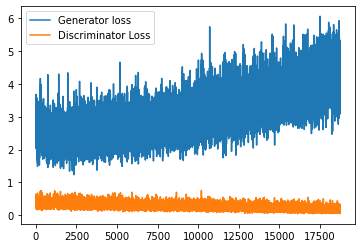

In [244]:
plt.figure()
plt.plot(g_losses, label='Generator loss')
plt.plot(d_losses, label='Discriminator Loss')
plt.legend()
plt.show()

## a. Plot 10 samples generated using the GAN


In [245]:
noise = sample_noise(10,128)
generated_imgs = generator(noise.cuda())

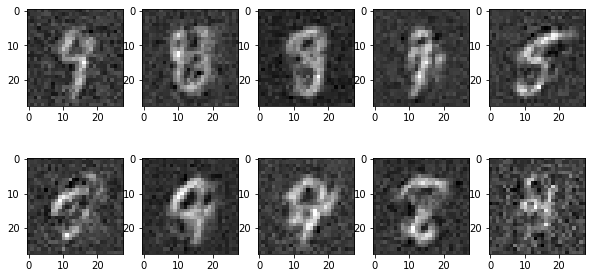

In [246]:
fig = plt.figure(figsize=(10, 5))
columns = 5
rows = 2
counter = 0
for img in generated_imgs:
    img_new = img.detach().cpu().numpy()
    fig.add_subplot(rows, columns, counter+1)
    plt.imshow(img_new, cmap="gray")
    counter += 1
plt.show()

## b. Finally, train a classifier C that classifies MNIST images. Use that classifier to approximate the marginal distribution of the generator p(y), (i.e. the probability that the GAN samples a particular class). Visualize the distribution using a bar-plot 

**Step 1: Train a model on the MNIST data set**

In [247]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
model.cuda()
model.train()
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
epochs = 10
for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        images, labels = images.cuda(), labels.cuda()
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(train_loader)))


KeyboardInterrupt: ignored

In [170]:
correct_count, all_count = 0, 0
for images,labels in test_loader:
  for i in range(len(labels)):
    tmp = images[i].cuda()
    img = tmp.view(1, 784)
    with torch.no_grad():
        logps = model(img)

    
    ps = torch.exp(logps)
    probab = list(ps.cpu().detach().numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9784


**Step 2: Generate x many fake MNIST samples with trained GAN**

In [ ]:
noise = sample_noise(100,128)
generated_imgs = generator(noise.cuda())

**Step 3: Apply C to fake MNIST set and evaluate density over predicted digits**

In [222]:
GAN_labels = [] 
for im in generated_imgs:
  logps = model(im.reshape([-1,784]))
  ps = torch.exp(logps).cpu().detach()
  probab = list(ps.numpy()[0])
  pred_label = probab.index(max(probab))
  GAN_labels.append(pred_label)


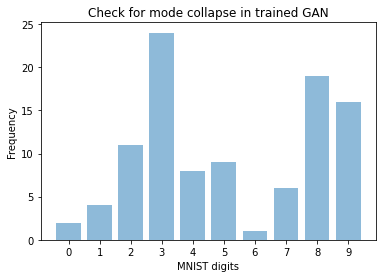

In [235]:
objects = list(range(10))
y_pos = np.arange(len(objects))
counts = [GAN_labels.count(c) for c in range(10)]

plt.bar(y_pos, counts, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.title('Check for mode collapse in trained GAN')
plt.xlabel('MNIST digits')
plt.ylabel('Frequency')

plt.show()


## c. You can use one-to-one updates applying one gradient step for the discriminator and generator successively. If you want to keep this simple you can also just use linear layer